In [1]:
import import_ipynb
import utils
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split


In [29]:
# préparation des données pour l'entrainement de 1992 - 2020
data_pop = utils.generate_df_from_files("./data_cleaned/population", "_population")
data_fertility = utils.generate_df_from_files("./data_cleaned/fertility", "_fertility")
data_child = utils.generate_df_from_files("./data_cleaned/child_mortality", "_child_mortality")
data_capita = utils.generate_df_from_files("./data_cleaned/gdp_capita", "_gdp_capita")
data_climat = utils.generate_df_from_files("./", "climate_cleaned")

data_climat = np.array(data_climat)
data_climat = pd.DataFrame(data_climat.squeeze())
X_list = []

for annee in range(11, 19):
        
    data_pop_slice = data_pop[annee].iloc[:, :]
    data_fertility_slice = data_fertility[annee].iloc[:, 1:]
    data_child_slice = data_child[annee].iloc[:, 1:]
    data_capita_slice = data_capita[annee].iloc[:, 1:]
    data_climat_slice = data_climat.iloc[:, 1:]
    
    concatenated_data = np.concatenate((
        data_pop_slice, 
        data_fertility_slice, 
        data_child_slice, 
        data_capita_slice,
        data_climat_slice
    ), axis=1)

    X_list.append(concatenated_data)

X = np.vstack(X_list)

In [30]:
#preparation des labels pour classification 1992-->2020
import pandas as pd

label_class = pd.read_csv("labels_class.csv")
label_class.head()

labels_list = []
for i in range(len(label_class)):
    label = label_class.iloc[i, :-1]
    labels_list.append(label)

y_class = pd.concat(labels_list, axis=0, ignore_index=True)

In [ ]:
y_class.unique()

array([0, 1, 2], dtype=int64)

In [33]:
# création des label pour tous les événements 1992->2020
import pandas as pd
df_delegations = pd.read_csv("./second_part_countries_cleaned_normalized.csv")

labels_list = []
for i in range(len(df_delegations)):
    label = df_delegations.iloc[i, :-1]
    labels_list.append(label)

y = pd.concat(labels_list, axis=0, ignore_index=True)


In [34]:

#récupération des pays
country_names = X[:, 0]
X = X[:, 1:]
# convertion des données en float32
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
y_class = np.array(y_class, dtype=np.float32)
# séparation des données en train et test
X_train, X_test, y_train, y_test, country_train, country_test, cl_train, cl_test = train_test_split(
    X, y, country_names, y_class,  test_size=0.2, random_state=42)



Epoch 1/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2633 - loss: 0.0290 - val_accuracy: 0.2656 - val_loss: 0.0372
Epoch 2/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2638 - loss: 0.0313 - val_accuracy: 0.2656 - val_loss: 0.0372
Epoch 3/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2558 - loss: 0.0294 - val_accuracy: 0.2656 - val_loss: 0.0372
Epoch 4/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2759 - loss: 0.0357 - val_accuracy: 0.2656 - val_loss: 0.0372
Epoch 5/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2480 - loss: 0.0419 - val_accuracy: 0.2656 - val_loss: 0.0372
Epoch 6/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2698 - loss: 0.0307 - val_accuracy: 0.2656 - val_loss: 0.0372
Epoch 7/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2451 - loss: 0.0272 - val_accuracy: 0.2656 - val_loss: 0.0372
Epoch 8/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2835 - loss: 0.0332 - val_accuracy: 0.2656 - val_loss

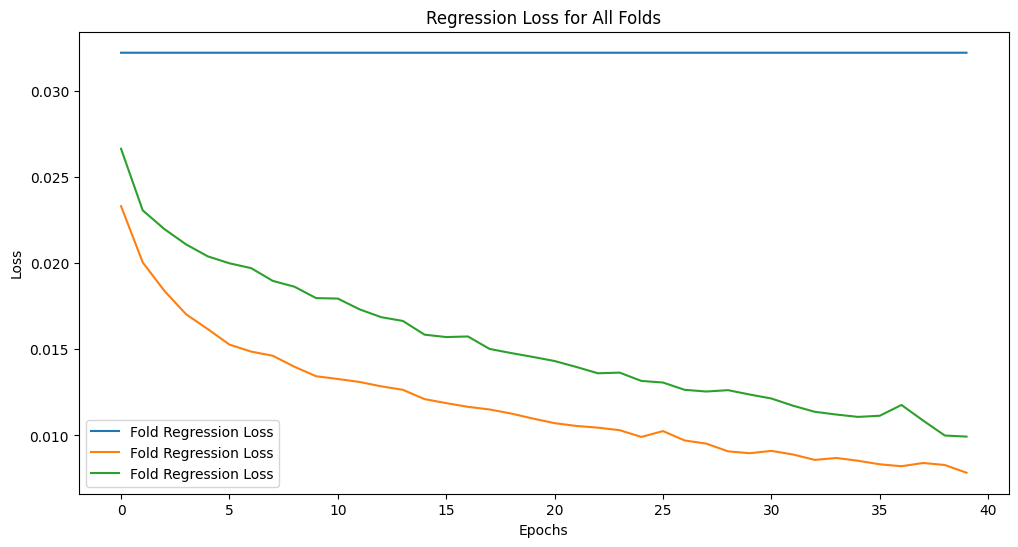

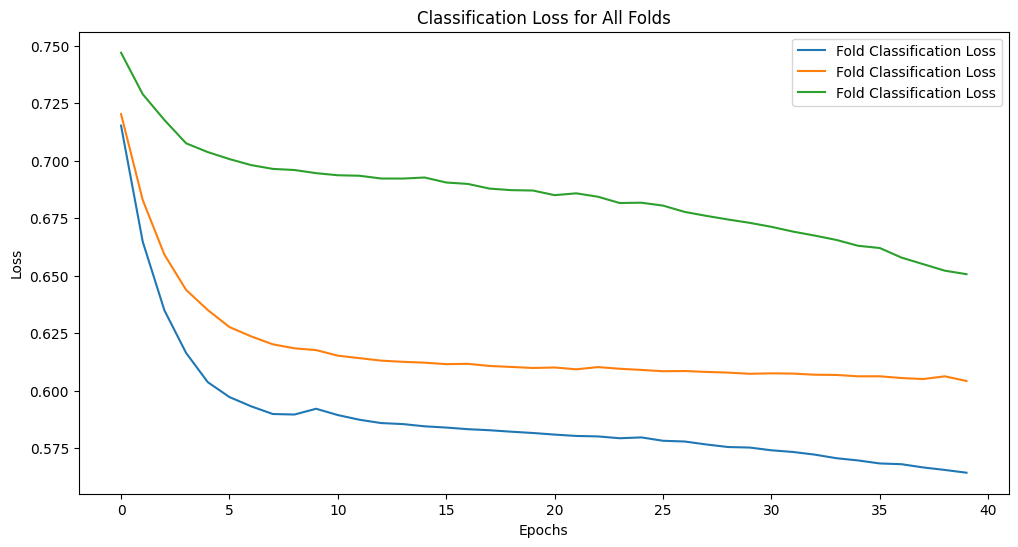

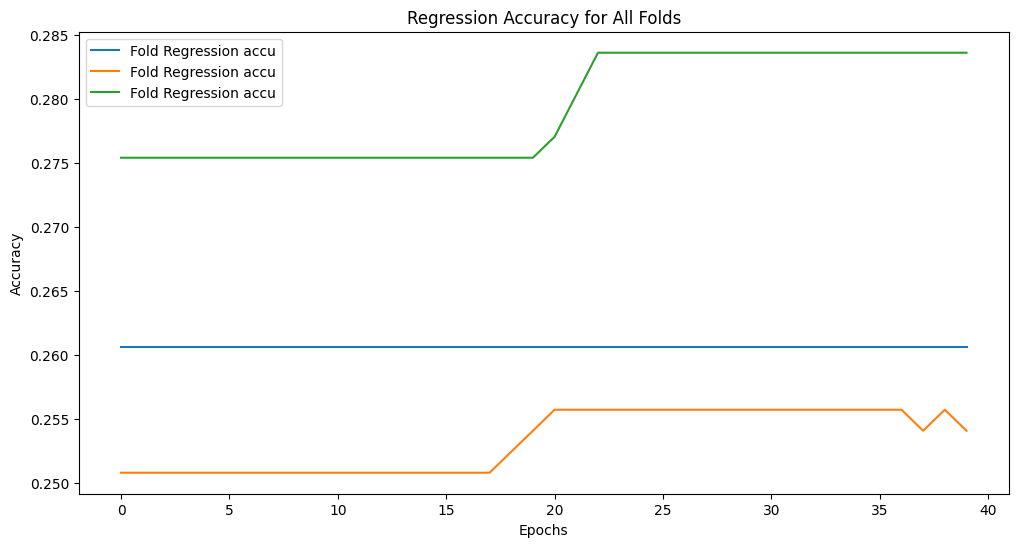

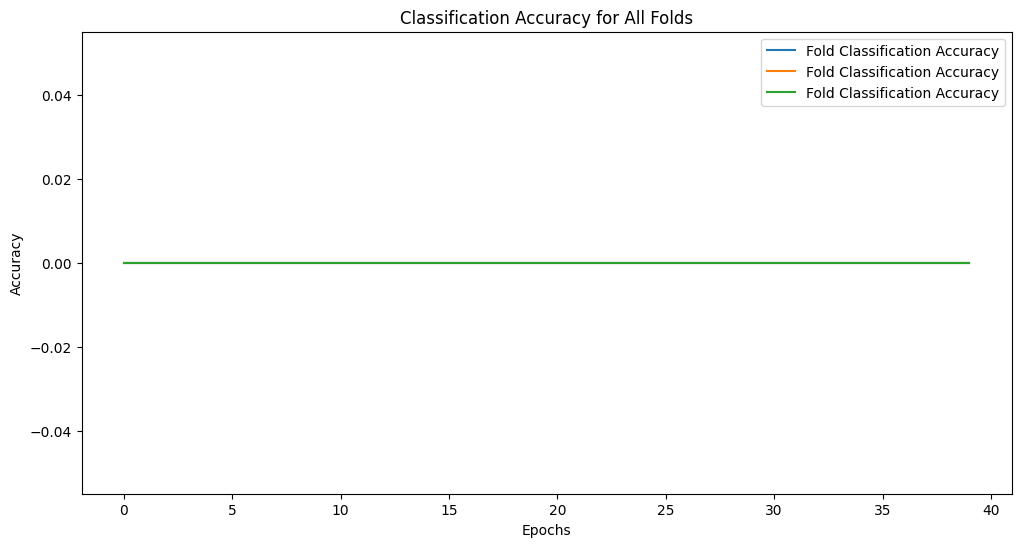

Average Regression Loss: 0.016662898163000744
Average Classification Loss: 0.6063843369483948
Average Regression Accuracy: 0.26229508717854816
Average Classification Accuracy: 0.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import MeanSquaredError as MSE, Accuracy
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy


# Number of folds for cross-validation
n_folds = 3
N_EP = 40

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Store results
regression_loss_per_fold = []
classification_loss_per_fold = []
regression_mse_per_fold = []
classification_accuracy_per_fold = []

# Compute class weights for the classification task
class_weights = compute_class_weight('balanced', classes=np.unique(cl_train), y=cl_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Training loop for cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    cl_train_fold, cl_val_fold = cl_train[train_index], cl_train[val_index]

    # ** Convert the classification labels to one-hot encoding **
    cl_train_fold_onehot = to_categorical(cl_train_fold, num_classes=3)  # 3 classes
    cl_val_fold_onehot = to_categorical(cl_val_fold, num_classes=3)

    # ** Regression Model **
    regression_inputs = Input(shape=(X_train.shape[1],))
    x1_reg = Dense(16, activation='relu')(regression_inputs)
    x2_reg = Dense(8, activation='relu')(x1_reg)
    output_reg = Dense(1, activation='relu', name='regression_output')(x2_reg)

    regression_model = Model(inputs=regression_inputs, outputs=output_reg)
    regression_model.compile(
        optimizer=Adam(),
        loss=MeanSquaredError(),
        metrics=['accuracy']  # Using accuracy for regression
    )

    # ** Classification Model **
    classification_inputs = Input(shape=(X_train.shape[1],))
    x1_clf = Dense(16, activation='relu')(classification_inputs)
    x2_clf = Dense(8, activation='relu')(x1_clf)
    output_clf = Dense(3, activation='softmax', name='classification_output')(x2_clf)  # Softmax for multi-class

    classification_model = Model(inputs=classification_inputs, outputs=output_clf)
    classification_model.compile(
        optimizer=Adam(),
        loss=CategoricalCrossentropy(),  # Multi-class loss
        metrics=[Accuracy()]
    )

    # EarlyStopping to prevent overfitting (if needed)
    # early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # ** Training the Regression Model **
    regression_history = regression_model.fit(
        X_train_fold,
        y_train_fold,
        epochs=N_EP,
        batch_size=16,
        validation_data=(X_val_fold, y_val_fold),
        verbose=1
        #callbacks=[early_stopping]
    )

    # ** Training the Classification Model with class weights **
    classification_history = classification_model.fit(
        X_train_fold,
        cl_train_fold_onehot,  # Use one-hot encoded labels
        epochs=N_EP,
        batch_size=16,
        validation_data=(X_val_fold, cl_val_fold_onehot),  # Validation data as one-hot encoded labels
        class_weight=class_weight_dict,  # Apply class weights here
        verbose=1
        #callbacks=[early_stopping]
    )

    # Collect the losses and metrics for regression and classification
    regression_loss_per_fold.append(regression_history.history['loss'])
    classification_loss_per_fold.append(classification_history.history['loss'])
    regression_mse_per_fold.append(regression_history.history['accuracy'])  # Regression accuracy
    classification_accuracy_per_fold.append(classification_history.history['accuracy'])

# Plotting the results for Regression and Classification models

# ** Regression Loss **
plt.figure(figsize=(12, 6))
for loss in regression_loss_per_fold:
    plt.plot(loss, label='Fold Regression Loss')
plt.title('Regression Loss for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ** Classification Loss **
plt.figure(figsize=(12, 6))
for loss in classification_loss_per_fold:
    plt.plot(loss, label='Fold Classification Loss')
plt.title('Classification Loss for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ** Regression Accuracy (or MSE) **
plt.figure(figsize=(12, 6))
for mse in regression_mse_per_fold:
    plt.plot(mse, label='Fold Regression accu')
plt.title('Regression Accuracy for All Folds')  # or "Regression MSE"
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  # or "MSE"
plt.legend()
plt.show()

# ** Classification Accuracy **
plt.figure(figsize=(12, 6))
for acc in classification_accuracy_per_fold:
    plt.plot(acc, label='Fold Classification Accuracy')
plt.title('Classification Accuracy for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ** Average Metrics **
avg_regression_loss = np.mean([np.min(loss) for loss in regression_loss_per_fold])
avg_classification_loss = np.mean([np.min(loss) for loss in classification_loss_per_fold])
avg_regression_mse = np.mean([np.min(mse) for mse in regression_mse_per_fold])
avg_classification_accuracy = np.mean([np.max(acc) for acc in classification_accuracy_per_fold])

print(f'Average Regression Loss: {avg_regression_loss}')
print(f'Average Classification Loss: {avg_classification_loss}')
print(f'Average Regression Accuracy: {avg_regression_mse}')  # Or MSE
print(f'Average Classification Accuracy: {avg_classification_accuracy}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


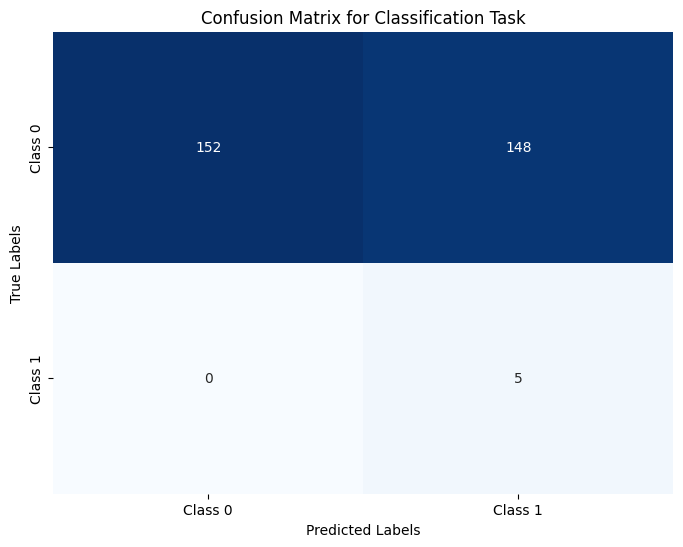

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean F1 Score across all folds: 0.1080
Mean Accuracy Score across all folds: 0.5432


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions for classification on validation set
y_pred_class = classification_model.predict(X_val_fold)
y_pred_class = (y_pred_class > 0.5).astype(int)  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(cl_val_fold, y_pred_class)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Classification Task')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
from sklearn.metrics import f1_score, accuracy_score

# Lists to store F1 and accuracy scores for each fold
f1_scores_per_fold = []
accuracy_scores_per_fold = []

# Loop through each fold to evaluate metrics
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    cl_train_fold, cl_val_fold = cl_train[train_index], cl_train[val_index]

    # Make predictions for the classification model on the validation set
    y_pred_class = classification_model.predict(X_val_fold)
    y_pred_class = (y_pred_class > 0.5).astype(int)  # Convert probabilities to class labels

    # Calculate F1 score and accuracy for the current fold
    f1 = f1_score(cl_val_fold, y_pred_class)
    accuracy = accuracy_score(cl_val_fold, y_pred_class)

    # Append scores to the lists
    f1_scores_per_fold.append(f1)
    accuracy_scores_per_fold.append(accuracy)

# Calculate the mean F1 score and accuracy score across all folds
mean_f1_score = np.mean(f1_scores_per_fold)
mean_accuracy_score = np.mean(accuracy_scores_per_fold)

# Print the mean scores
print(f'Mean F1 Score across all folds: {mean_f1_score:.4f}')
print(f'Mean Accuracy Score across all folds: {mean_accuracy_score:.4f}')



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
# version simple du NN en format NON séquentiel
"""

inputs = Input(shape=(X_train.shape[1],))

x = Dense(50, activation='relu')(inputs)
#x = Dropout(0.3)(x)

#x = Dense(16, activation='relu')(x)
#x = Dropout(0.3)(x)

x = Dense(12, activation='relu')(x)

outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.2, verbose=1)
"""

"\n\ninputs = Input(shape=(X_train.shape[1],))\n\nx = Dense(50, activation='relu')(inputs)\n#x = Dropout(0.3)(x)\n\n#x = Dense(16, activation='relu')(x)\n#x = Dropout(0.3)(x)\n\nx = Dense(12, activation='relu')(x)\n\noutputs = Dense(1)(x)\n\nmodel = Model(inputs=inputs, outputs=outputs)\n\nmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])\n\nhistory = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.2, verbose=1)\n"